### Will a Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaraunt near where you are driving. Would you accept that coupon and take a short detour to the restaraunt? Would you accept the coupon but use it on a sunbsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaraunt? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \\$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\\$20 - \\$50). 

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece. 





### Data Description
Keep in mind that these values mentioned below are average values.

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

### Imports

In [291]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import random
import plotly.express as px
from IPython.display import Image
from typing import Union, List

### Data Load

#### Read in the `coupons.csv` file

In [292]:
df_in = pd.read_csv("./data/coupons.csv")

Function generates a compact data frame with number of rows given by the maximum number of unique elements in any column  
- Columns with fewer elements than that maximum provide more via random selection drawn from its unique set  
- This frame scrambles the data in any given row, so it is not for exploitation purposes, but to give a look at all the information in the frame

In [293]:
def random_unique_vals(series: pd.Series = None, nunique: int = 0) -> pd.Series:
    unique_vals = series.unique().tolist()
    return pd.Series(
        unique_vals + random.choices(unique_vals, k=nunique - len(unique_vals))
    )


def unique_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    random.seed(0)
    return df.apply(
        random_unique_vals, nunique=df.apply(lambda x: len(x.unique())).max()
    )

#### Investigate the dataset for missing or problematic data

In [294]:
pd.set_option("display.max_columns", None)
display(unique_dataframe(df_in).head(5))

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,Home,Friend(s),Rainy,80,10AM,Coffee House,2h,Male,46,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,Scooter and motorcycle,less1,less1,4~8,1~3,less1,1,1,1,1,0,0
2,Work,Kid(s),Snowy,30,6PM,Carry out & Take away,1d,Male,26,Married partner,1,Associates degree,Student,$12500 - $24999,crossover,1~3,4~8,1~3,less1,never,1,0,0,1,0,1
3,Work,Partner,Sunny,80,7AM,Bar,1d,Male,31,Divorced,0,High School Graduate,Education&Training&Library,$75000 - $87499,Mazda5,gt8,1~3,gt8,gt8,gt8,1,1,0,1,0,1
4,Work,Partner,Sunny,80,10PM,Restaurant(20-50),1d,Female,41,Widowed,0,Graduate degree (Masters or Doctorate),Healthcare Support,$50000 - $62499,do not drive,NaN,gt8,less1,NaN,4~8,1,1,0,1,0,1


By just viewing the first few rows of the compact frame, we see many problems:  
- There are NaN present in several categories (`car`, `Bar`, etc...)
- Some values were overly complicated, for example, in the `coupon` category, *Carry out & Take away* can be simplified to *Carry Out*
- There is ostensibly numeric data hiding in range-like strings, such as 4~8 which means 4 to 8 visits per month
- Many of the column names, such as `toCoupon_GEQ5min` and `RestaurantLessThan20`

### Data Cleaning

#### Decide what to do about your missing data -- drop, replace, other...

#### Change Summary

Here is a summary of changes I made. A complete description is in the file in `./data/coupons_cleanup_dict.json`

##### Dropped Unusable or Redundant Columns
- `car` because out of 12,000 rows in the data frame, only about 100 were non-null
- `direction_opp` redundant because it is the logical negation of `direction_same`
##### Renamed Columns for Clarity
I renamed various columns so their meanings were self evident:
- `passanger` renamed `passenger`
- `toCoupon_GEQ<N>min` renamed `AtLeast<N>MinutesDriveToRedeem`
- `income` renamed `AvgAnnualIncome`
- `direction_same` renamed `CanRedeemEnRoute`
- Added prefix `AvgMonthlyVisitsTo` columns `Bar`, `CoffeeHouse`, `CarryAway`, and `Restaurant*`
- - e.g `Bar` renamed `AvgMonthlyVisitsToBar`
##### Strings to Equivalent Floats
- Several categories contained strings encoding numeric ranges, which would be difficult to query for
- So I converted them to the mean of the range
- - e.g. in the average monthly visits columns, "4~8" was converted to 6.0
##### Simplified
- Multi-word values were reduced to single-word values with equivalent meaning
- - e.g. "Married partner" was simplified to "Married"
- Suffixes which add no additional meaning were removed, e.g. `Kid(s)` was shortened to `Kid`

#### Perform Cleanups

##### Cleanup Functions

In [295]:
# Convert a string representing a range to its mean, e.g. str("1 - 2") -> float(1.5)
def range_to_mean(element: str, sep: str = "-") -> float:
    if isinstance(element, str):
        return np.array(list(map(float, element.replace(" ", "").split(sep)))).mean()
    else:
        return element

In [296]:
cleanup_dict = json.load(open("./data/coupons_cleanup_dict.json", "r"))


def cleanup_series(
    series: pd.Series = None,
) -> pd.Series:
    # Get cleanup dict for this series or return
    if series.name not in cleanup_dict:
        return series

    column_cleanup_dict = cleanup_dict[series.name]
    if "key" in column_cleanup_dict:
        # Take a different cleanup if a key is provided
        column_cleanup_dict = cleanup_dict[column_cleanup_dict["key"]]

    # Substring replace (many to one) with regex
    if "str.replace" in column_cleanup_dict:
        pattern = "|".join(column_cleanup_dict["str.replace"][0])
        series = series.str.replace(
            pattern, column_cleanup_dict["str.replace"][1], regex=True
        )

    # Whole-word replace (one to one) without regex
    if "replace" in column_cleanup_dict:
        series = series.replace(column_cleanup_dict["replace"], regex=False)

    # Apply a function
    if "apply" in column_cleanup_dict:
        series = series.apply(eval(column_cleanup_dict["apply"]))

    return series

##### Run the Cleanup On all Columns

In [297]:
# Extract iterables for dropping and renaming columns
drop_list = [key for key in cleanup_dict if "drop" in cleanup_dict[key]]
rename_dict = {
    key: cleanup_dict[key]["rename"]
    for key in cleanup_dict
    if "rename" in cleanup_dict[key]
}

# Perform the cleanups per column as defined by cleanups dict
df = (
    df_in.copy(deep=True)
    .drop(drop_list, axis=1)
    .apply(cleanup_series)
    .rename(columns=rename_dict)
)

The awkward extraction for the `drop_list` and `rename_dict` results from the way I organized the data in the `cleanup_dict` as

```
{
Column-A:{drop:T/F, rename:rename-to, cleanup:yada-yada-yada},
...
Column-Z:{drop:T/F, rename:rename-to, cleanup:blah-blah-blah},
}
```

which makes it is easy to look at by column (tell me everything you did to column X)  
but harder to look at by cleanup category (what columns did you rename?)  

This column-wise organization is appealing, even if it costs a bit of cumbersome code when looking across columns.

#### Finish Cleanup Processing and Save Data

##### Drop Remaining NaN's and Display Final Compares

In [298]:
df.dropna(inplace=True)

display(unique_dataframe(df_in).head(5))
display(unique_dataframe(df).head(5))

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,Home,Friend(s),Rainy,80,10AM,Coffee House,2h,Male,46,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,Scooter and motorcycle,less1,less1,4~8,1~3,less1,1,1,1,1,0,0
2,Work,Kid(s),Snowy,30,6PM,Carry out & Take away,1d,Male,26,Married partner,1,Associates degree,Student,$12500 - $24999,crossover,1~3,4~8,1~3,less1,never,1,0,0,1,0,1
3,Work,Partner,Sunny,80,7AM,Bar,1d,Male,31,Divorced,0,High School Graduate,Education&Training&Library,$75000 - $87499,Mazda5,gt8,1~3,gt8,gt8,gt8,1,1,0,1,0,1
4,Work,Partner,Sunny,80,10PM,Restaurant(20-50),1d,Female,41,Widowed,0,Graduate degree (Masters or Doctorate),Healthcare Support,$50000 - $62499,do not drive,NaN,gt8,less1,NaN,4~8,1,1,0,1,0,1


,destination,passenger,weather,temperature,time,coupon,HoursToCouponExpiration,gender,age,maritalStatus,has_children,education,occupation,AvgAnnualIncome,AvgMonthlyVisitsToBar,AvgMonthlyVisitsToCoffeeHouse,AvgMonthlyVisitsToCarryAway,AvgMonthlyVisitsToRestaurantLessThan20,AvgMonthlyVisitsToRestaurant20To50,AtLeast5MinutesDriveToRedeem,AtLeast15MinutesDriveToRedeem,AtLeast25MinutesDriveToRedeem,CanRedeemEnRoute,Y
0,Nowhere,None,Sunny,55,2PM,RestaurantLessThan20,24.0,Male,21.0,Single,0,Bachelors,Architecture & Engineering,68749.5,0.0,0.0,6.0,6.0,0.0,1,0,0,0,1
1,Home,Friend,Rainy,80,10AM,CoffeeHouse,2.0,Female,46.0,Married,1,Some College,Student,18749.5,2.0,6.0,2.0,2.0,2.0,1,1,1,1,0
2,Work,Kid,Snowy,30,6PM,Bar,24.0,Female,26.0,Together,0,Associates,Education&Training&Library,81249.5,8.0,2.0,8.0,0.0,8.0,1,0,0,0,1
3,Work,Partner,Sunny,80,7AM,CarryAway,24.0,Female,31.0,Divorced,1,High School,Unemployed,56249.5,6.0,8.0,0.0,8.0,6.0,1,1,1,1,0
4,Work,Partner,Sunny,80,10PM,Restaurant20To50,24.0,Male,41.0,Widowed,1,Graduate,Healthcare Support,43749.5,2.0,0.0,6.0,2.0,8.0,1,1,1,0,1


The display shows that many multi-word values were simplified, range strings and "numeric strings" were converted to numeric values, NaN's were removed, and many columns gained readily understood names

### Initial Analyses

##### What proportion of the total observations chose to accept the coupon?

In [299]:
# Computes the acceptance rate as the number of rows with Y = 1 relative to all the rows, in percent
def calc_acceptance_rate(
    df: pd.DataFrame = None,
) -> float:
    return len(df.query("Y == 1")) / len(df) * 100.0

In [300]:
calc_acceptance_rate(df)

56.93352098683666

57% of the total observations chose to accept the coupon

##### Use a bar plot to visualize the `coupon` column

This is a bar plot of the number of coupons offered per establishment type  
The plot shows that more coupons were offered for coffee houses than any other establishment

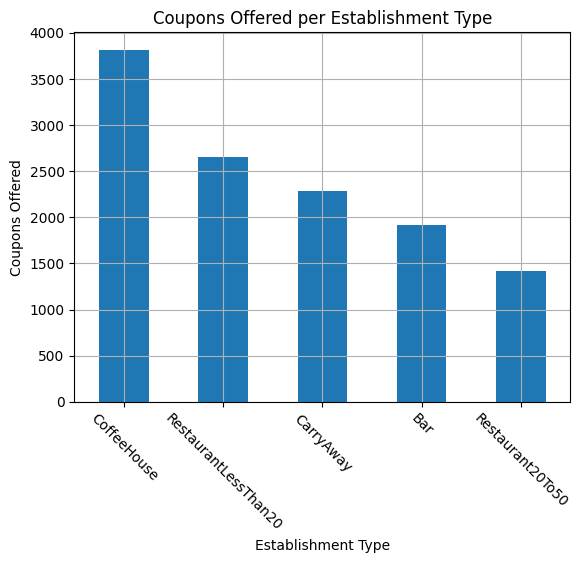

In [301]:
df.groupby("coupon")["Y"].agg(["count"]).reset_index().sort_values(
    by="count", ascending=False
).plot(
    x="coupon",
    y="count",
    kind="bar",
    legend=False,
    xlabel="Establishment Type",
    ylabel="Coupons Offered",
    title="Coupons Offered per Establishment Type",
    grid=True,
    rot=-45,
);

##### Use a histogram to visualize the temperature column

This is a histogram of the temperatures during days when coupons were offered  
The plot shows that coupons were offered most often on days when the temperature was 80 degrees

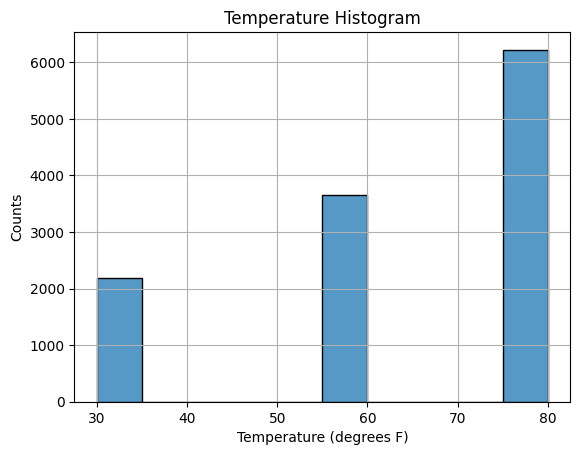

In [302]:
sns.histplot(data=df, x="temperature", bins=10, palette=sns.color_palette("bright")[:3])
plt.grid(True)
plt.xlabel("Temperature (degrees F)")
plt.ylabel("Counts")
plt.title("Temperature Histogram");

### Investigating the Bar Coupons

Now, we will lead you through an exploration of just the bar related coupons.  

##### 1. Create a new `DataFrame` that contains just the bar coupons

In [303]:
df_bar = df.query("coupon == 'Bar'")

##### 2. What proportion of bar coupons were accepted?

In [304]:
calc_acceptance_rate(df_bar)

41.19184526921067

41% of bar coupons were accepted

##### 3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more


In [305]:
mask = df_bar["AvgMonthlyVisitsToBar"] <= 3
[calc_acceptance_rate(df_bar[mask]), calc_acceptance_rate(df_bar[~mask])]

[37.26744186046512, 76.16580310880829]

People who went to a bar 3 or fewer times accepted at about half the rate (37%) to those who went more (76%)

##### 4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others - is there a difference?

In [306]:
mask_more_than_once = df_bar["AvgMonthlyVisitsToBar"] > 1
mask = mask_more_than_once & (df_bar["age"] > 25)
[calc_acceptance_rate(df_bar[mask]), calc_acceptance_rate(df_bar[~mask])]

[68.98263027295285, 33.77483443708609]

Yes, there is a big difference  
Drivers who go to a bar more than once a month and are over the age of 25 accepted coupons more than twice as often (69%) as all others (34%)

##### 5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry (FF&F)

In [307]:
mask = (
    mask_more_than_once
    & (df_bar["passenger"] != "Kid")
    & (df_bar["occupation"] != "Farming Fishing & Forestry")
)
[calc_acceptance_rate(df_bar[mask]), calc_acceptance_rate(df_bar[~mask])]

[70.94339622641509, 29.790310918293567]

Drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than FF&F accepted the coupons more than twice as often (71%) as all others (30%)

The last condition - occupations other than FF&F - has no impact on the results because once reduced to the first 2 conditions, no one had an occupation of FF&F

##### 6. Compare the acceptance rates between those drivers who:

- Go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- Go to bars more than once a month and are under the age of 30 *OR*
- Go to cheap restaurants more than 4 times a month and income is less than 50K

In [308]:
rate1 = calc_acceptance_rate(
    df_bar[mask_more_than_once].query(
        "passenger != 'Kid' and maritalStatus != 'Widowed'"
    )
)
rate2 = calc_acceptance_rate(df_bar[mask_more_than_once].query("age < 30"))
rate3 = calc_acceptance_rate(
    df_bar.query("AvgMonthlyVisitsToRestaurantLessThan20 > 4 & AvgAnnualIncome < 50e3")
)
display([rate1, rate2, rate3])

[70.94339622641509, 71.95121951219512, 45.645645645645644]

Drivers whos go to bars more than once a month accept coupons about 70% of the time, but drivers with incomes less than 50k who frequently visit cheaper restaurants only accepted 45% of coupons

##### 7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

Hypothesize That

- These drivers are probably younger on average and perhaps single, with no children, essentially "young and single".  

- Interestingly, price-consciousness alone does not predict acceptance of bar coupons. For example, drivers who go to cheaper restaurants more than 4 times per month with income less than $50k might be described as "price conscious" and yet they accepted bar coupons only 45% of the time

### Independent Investigation: Investigating the Coffee House Coupons

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons

#### Focus on the Coffee House Coupons

Because it was the establishment type with the largest count

##### Create a new `DataFrame` that contains just the coffee coupons

In [309]:
df_coffee = df.query("coupon == 'CoffeeHouse'")

#### Grouped Acceptance Rates

Here we introduce the ability to calculate acceptance rates by unique elements in a column (or columns). We will use this throughout the remainder of this section.

In [310]:
# Computes acceptance rate and count in each element of the named grouping
def calc_grouped_acceptance_rates(
    df: pd.DataFrame = None, columns: str = ""
) -> pd.DataFrame:
    return (
        df.groupby(columns)
        .apply(
            lambda df: pd.Series(
                {"Acceptance Rate": calc_acceptance_rate(df), "Count": len(df)}
            )
        )
        .reset_index()
        .sort_values(by="Acceptance Rate", ascending=True)
    )

Here is an example of acceptance rates for each occupation

In [311]:
display(calc_grouped_acceptance_rates(df_coffee, columns="occupation").tail(5))

,occupation,Acceptance Rate,Count
22,Student,61.473684,475.0
11,Healthcare Support,61.538462,65.0
23,Transportation & Material Moving,61.842105,76.0
2,Building & Grounds Cleaning & Maintenance,72.727273,11.0
10,Healthcare Practitioners & Technical,76.056338,71.0


#### Acceptance Rates of Coffee Coupon by Single Categories

This is a plot helper function to form a bar graph of the grouped acceptance rates

In [312]:
to_image_kwargs = {"format": "png", "width": 1200, "scale": 2}

In [313]:
def plot_grouped_acceptance_rates(
    df: pd.DataFrame = None,
    render_image: bool = True,
) -> any:
    # Get the names of the variables to label the plot
    columns = list(df.columns[0 : -1 - 1])

    # Plot it
    fig = px.bar(
        df,
        x=columns[0] if len(columns) == 1 else None,
        y="Acceptance Rate",
        labels={"Acceptance Rate": "Acceptance Rate (%)"},
        color="Count",
        title="Acceptance Rate of Coffee Coupon by " + " and ".join(columns),
        height=600,
        text_auto="d",
    )

    fig.update_layout(xaxis_type="category")

    if render_image:
        # Using static images because github does not render the dynamic plots
        return fig.to_image(**to_image_kwargs)
    else:
        return fig

##### By Occupation

Here is a bar plot of acceptance rate vs. occupation. The color is the count (sample size) in the category analyzed. This is helpful for recognizing that a category may have a high rate of acceptance but only a limited number of samples in the result.

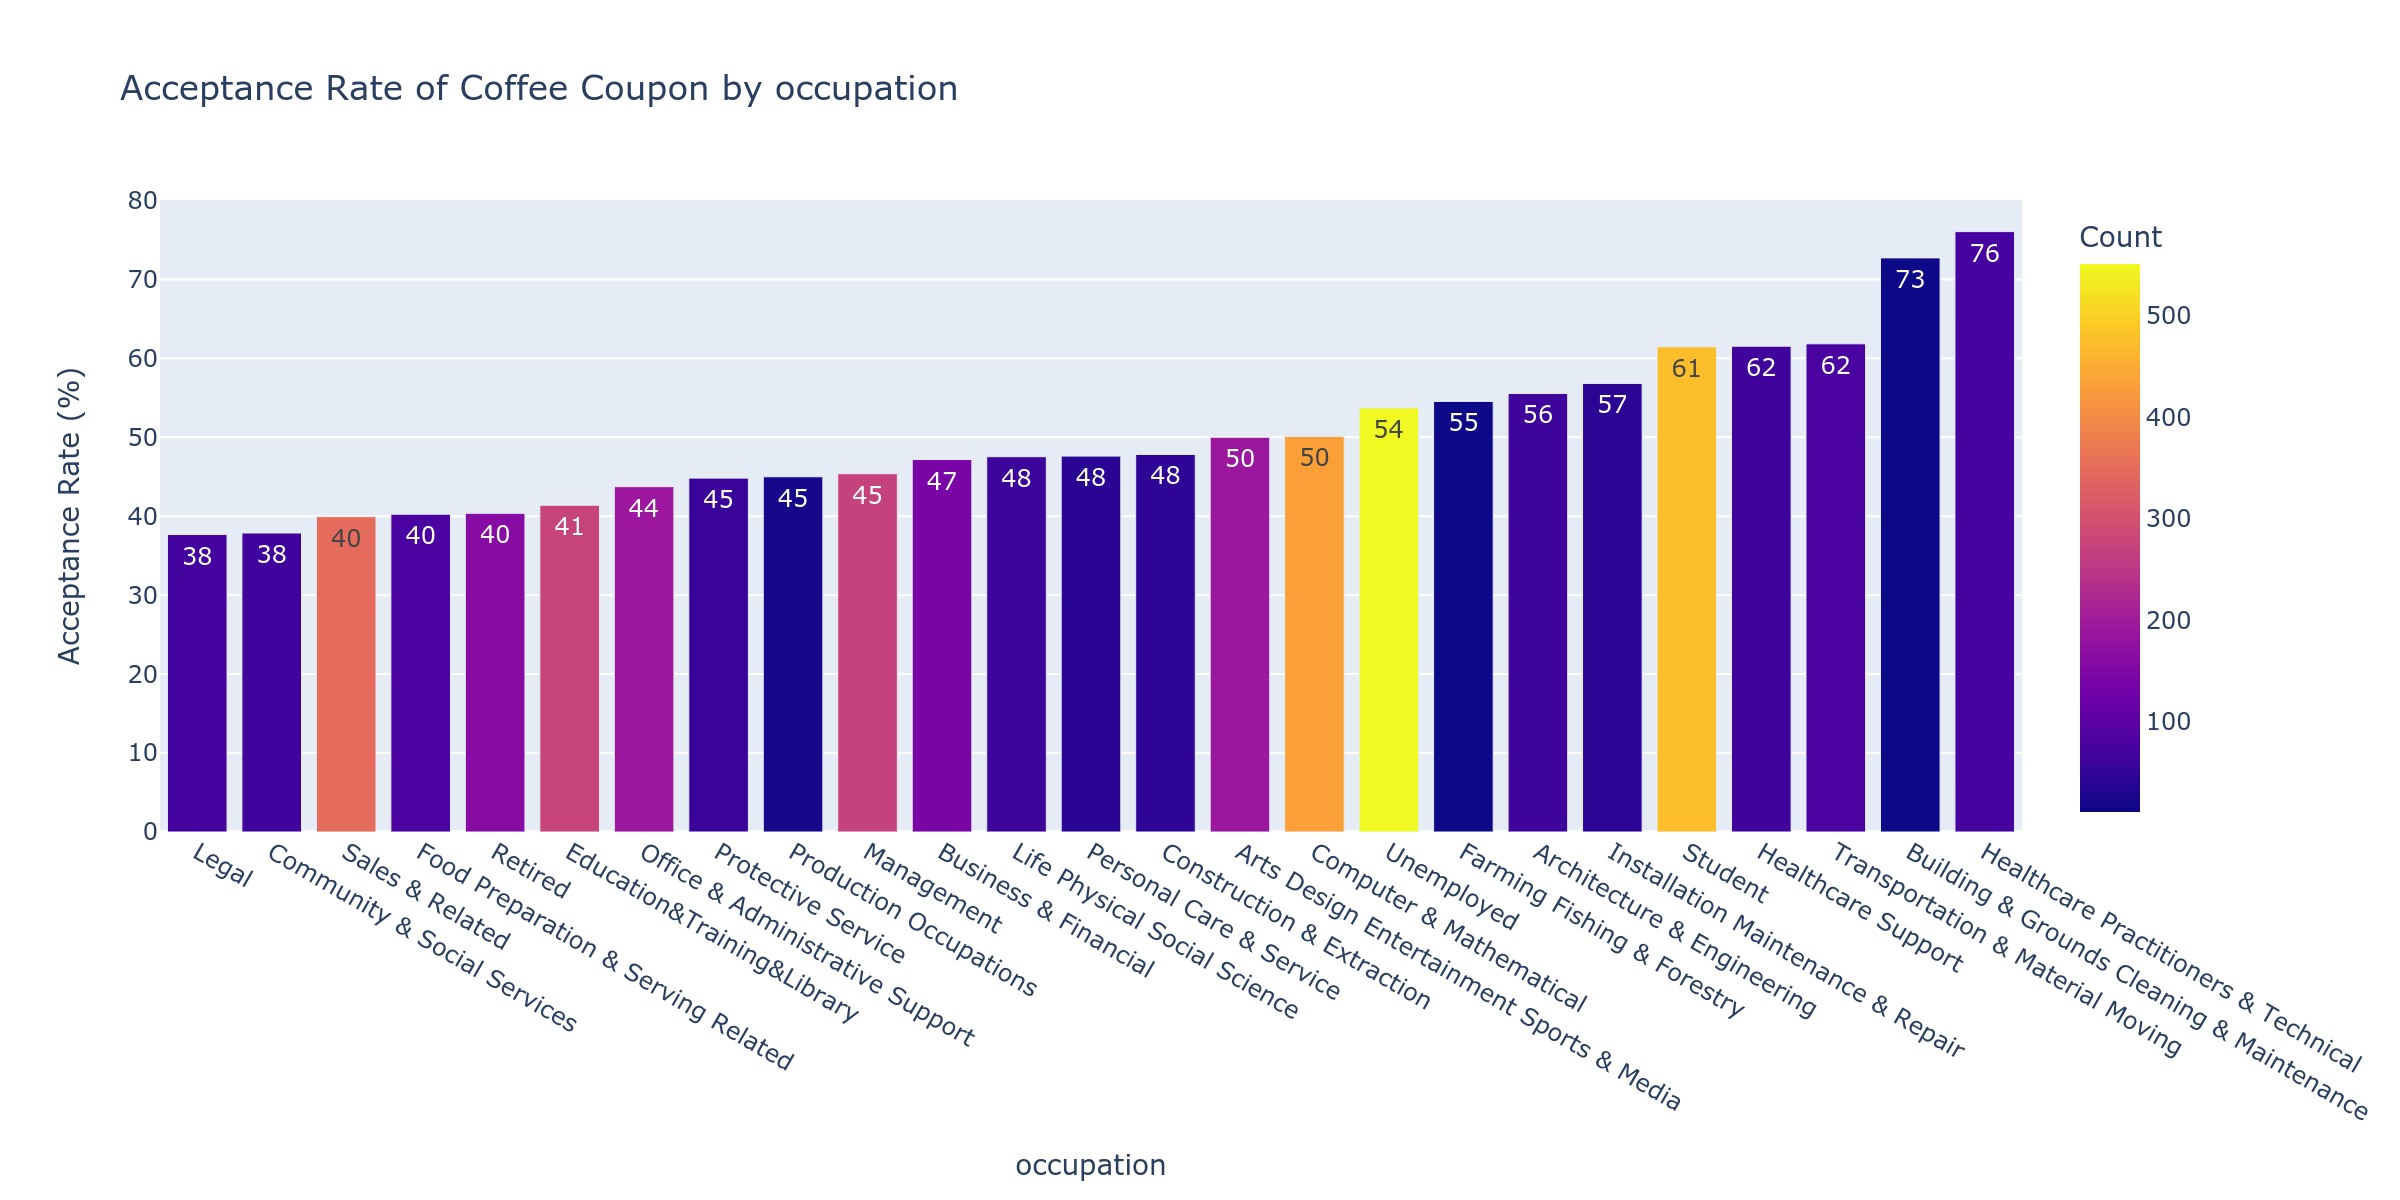

In [314]:
Image(
    plot_grouped_acceptance_rates(
        calc_grouped_acceptance_rates(df_coffee, columns="occupation")
    )
)

Those in the healthcare occupation had the highest rate of acceptance (76%).  
Surprisingly, retirees were among the least likely to accept at 40%
- One might guess retirees have both more time and less income than all others and therefore would accept coupons more often

##### By Number of Visits to a Coffee House in the Last Month

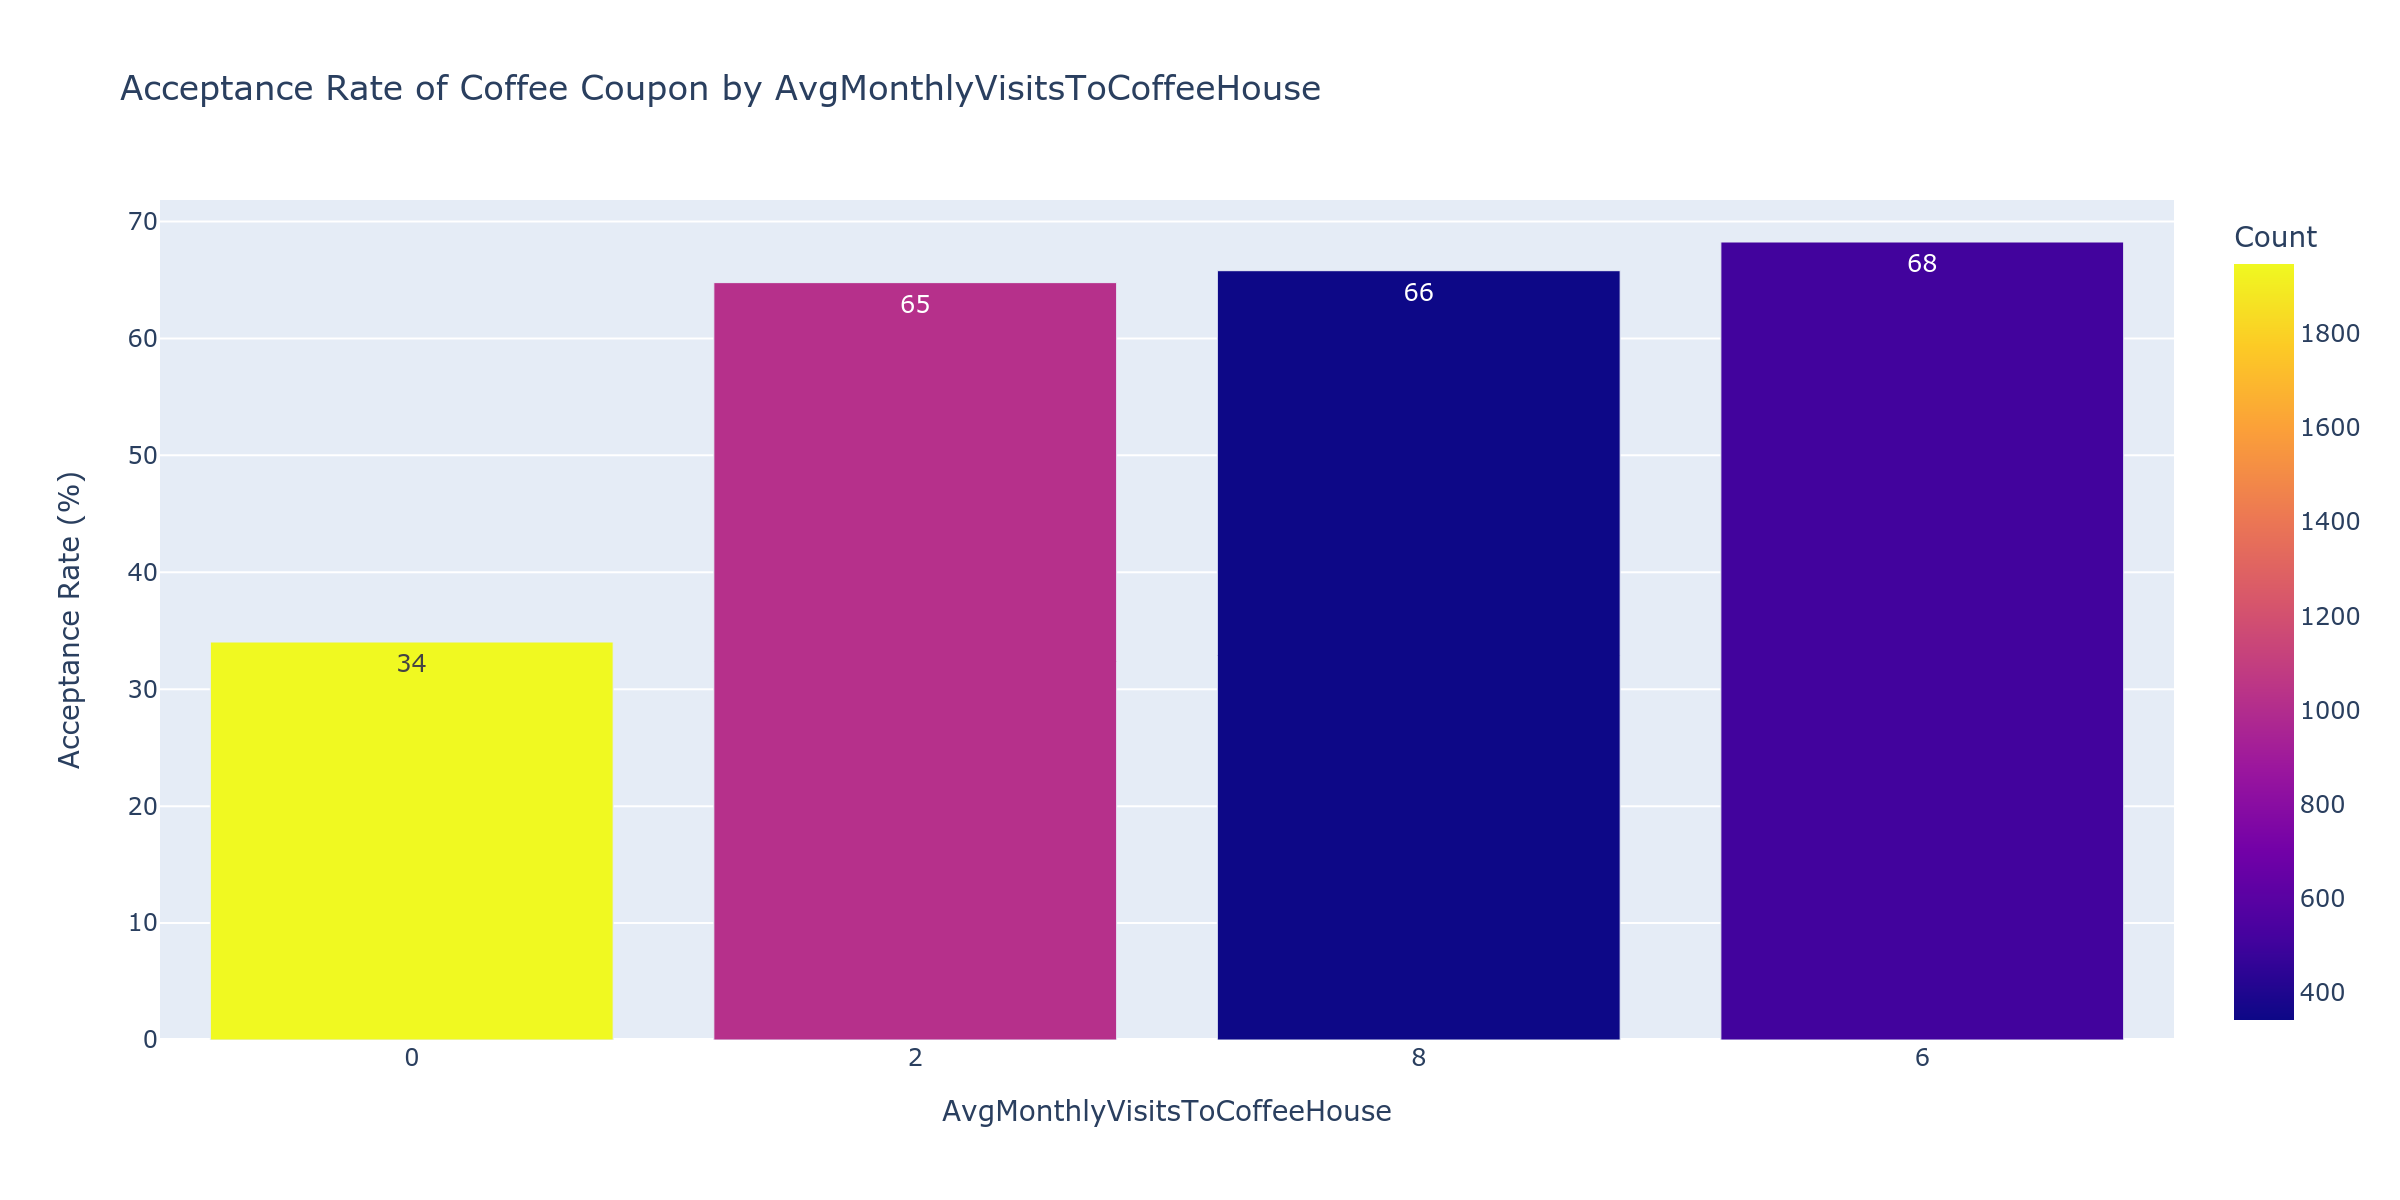

In [315]:
Image(
    plot_grouped_acceptance_rates(
        calc_grouped_acceptance_rates(
            df_coffee, columns="AvgMonthlyVisitsToCoffeeHouse"
        )
    )
)

Not too surprisingly, drivers who on average visited a coffee house at least 6 times in the last month accepted often - about 67% of the time

##### By Income

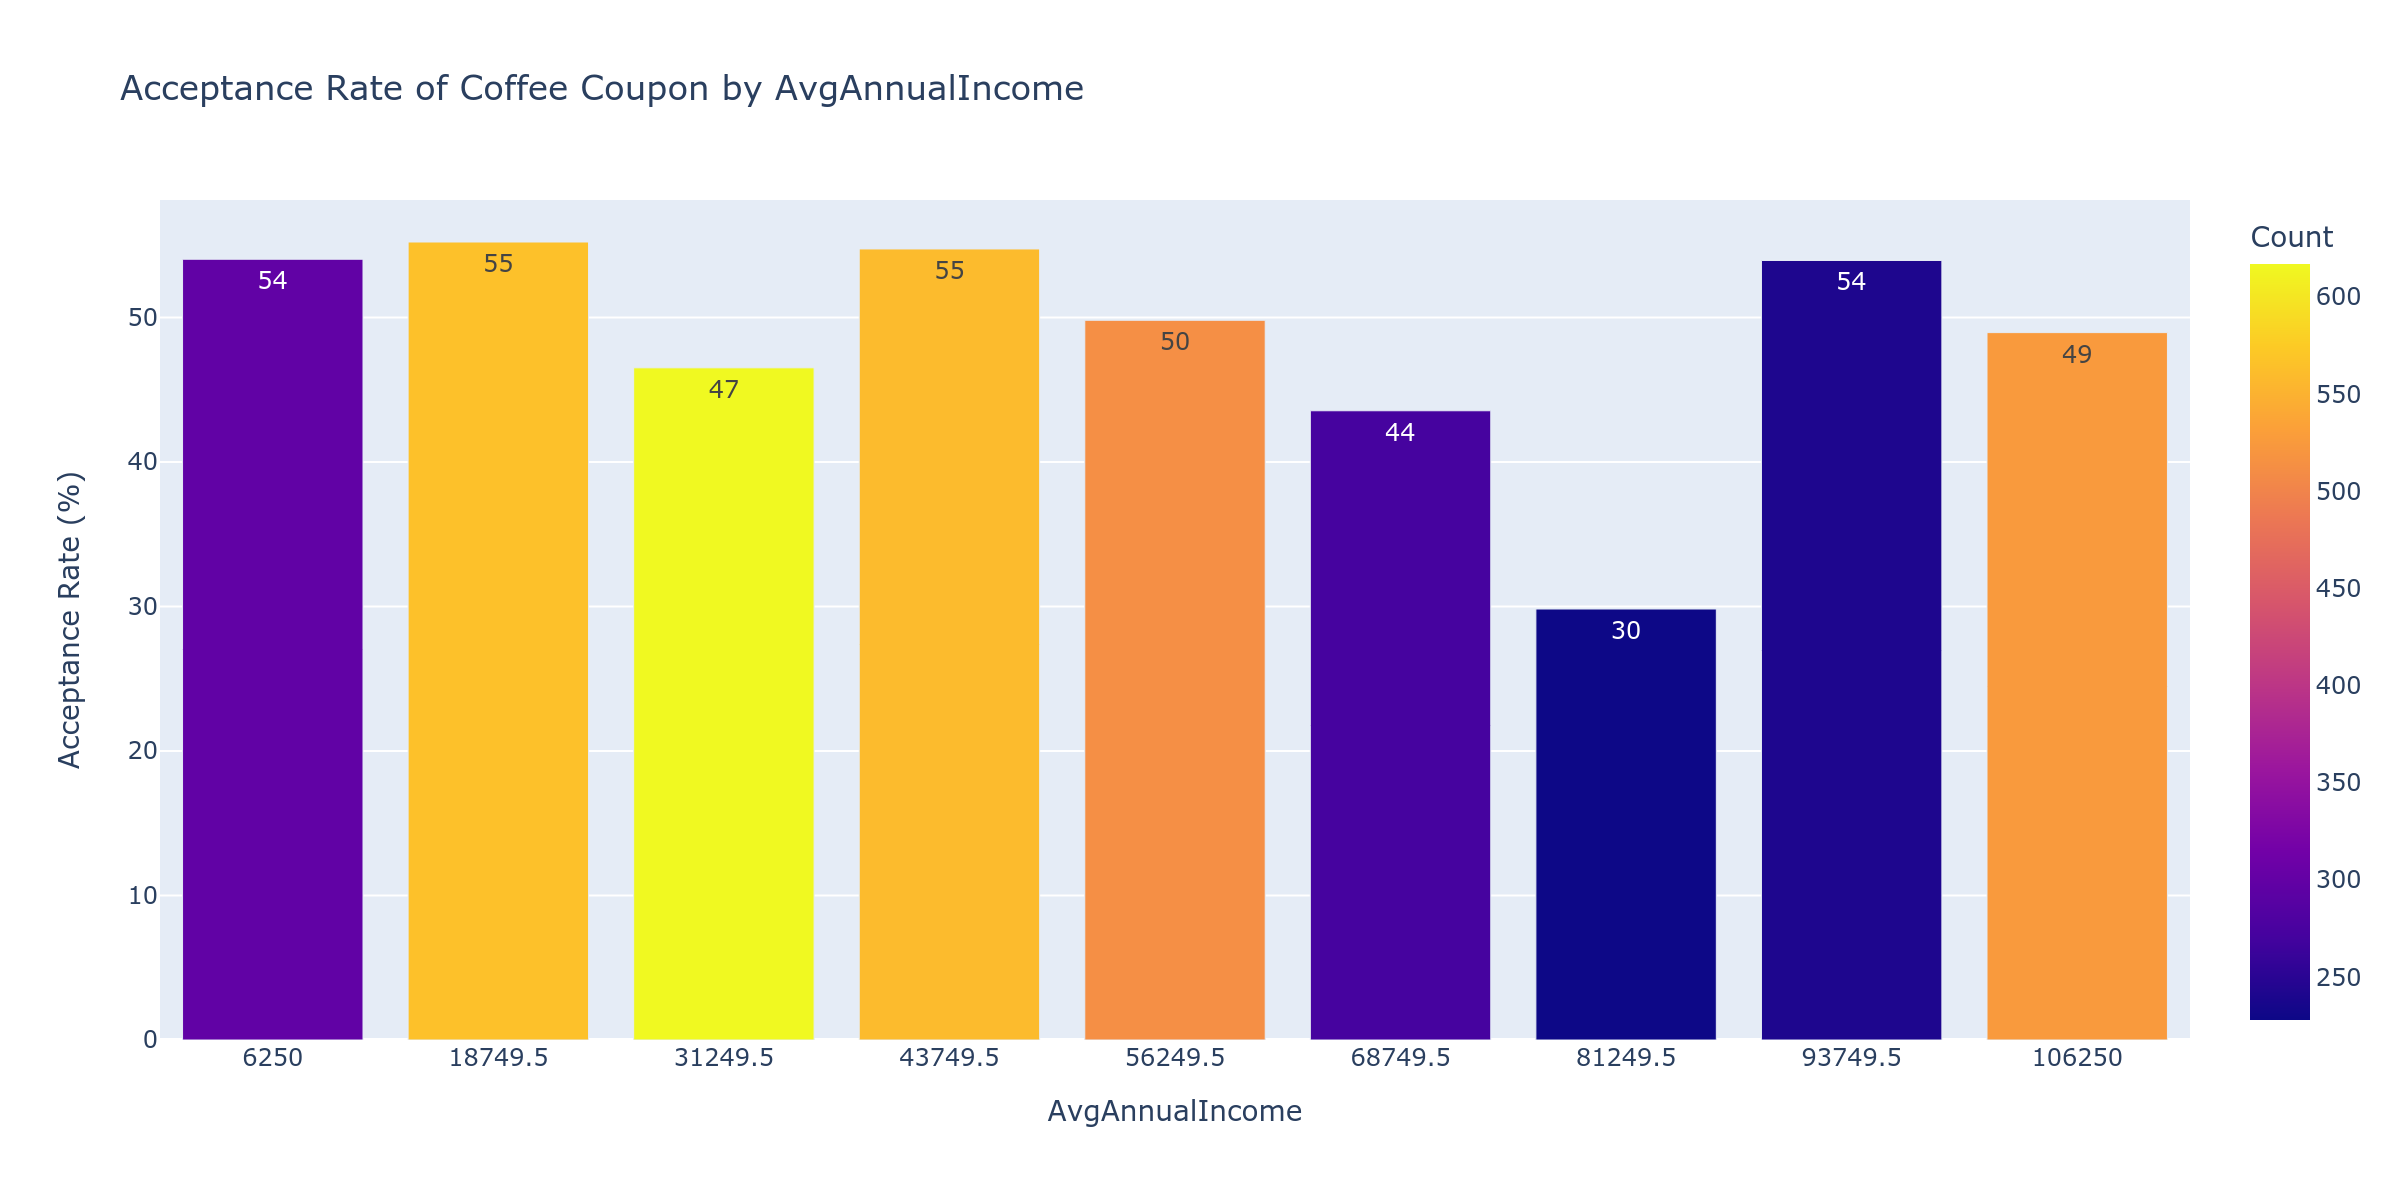

In [316]:
Image(
    plot_grouped_acceptance_rates(
        calc_grouped_acceptance_rates(df_coffee, columns="AvgAnnualIncome").sort_values(
            by="AvgAnnualIncome", ascending=True
        )
    )
)

The acceptance rate vs income reveals no consistent trend. Acceptance rates over 50% were seen at both extrema as well as the center of the income scale

#### Acceptance Rates of Coffee Coupon by Multiple Categories

From the above results, healthcare workers and those who visit coffee houses accept coupons at a fairly high rate.  
Combine these variables to look for even higher rates

In [317]:
display(
    calc_grouped_acceptance_rates(
        df_coffee, columns=["occupation", "AvgMonthlyVisitsToCoffeeHouse"]
    ).tail(10)
)

,occupation,AvgMonthlyVisitsToCoffeeHouse,Acceptance Rate,Count
9,Business & Financial,6.0,87.500000,16.0
29,Food Preparation & Serving Related,8.0,87.500000,8.0
31,Healthcare Practitioners & Technical,2.0,90.000000,30.0
76,Transportation & Material Moving,6.0,90.909091,11.0
32,Healthcare Practitioners & Technical,6.0,100.000000,6.0
56,Personal Care & Service,6.0,100.000000,4.0
20,Construction & Extraction,2.0,100.000000,7.0
53,Office & Administrative Support,6.0,100.000000,17.0
62,Protective Service,8.0,100.000000,10.0
38,Installation Maintenance & Repair,2.0,100.000000,14.0


Healthcare workers who visited a coffee house 2 times in the last months accepted 90% of coupons. However, the sample size of 30 is quite small.  
Those who visited 6 times per month accepted 100% of the coupons, but the sample size of 6 was smaller still.  
Integrate those 2 results from the health care works together to form a larger sample

In [318]:
visits = [2, 6]
display(
    calc_grouped_acceptance_rates(
        df_coffee.query("AvgMonthlyVisitsToCoffeeHouse in @visits"),
        columns=["occupation"],
    ).tail(5)
)

,occupation,Acceptance Rate,Count
10,Installation Maintenance & Repair,80.769231,26.0
16,Production Occupations,85.714286,7.0
5,Construction & Extraction,87.500000,16.0
8,Healthcare Practitioners & Technical,91.666667,36.0
15,Personal Care & Service,100.000000,4.0


Healthcare workers who visited coffee houses 2 or 6 times accepted 92% of coupons

##### View results from a similar experiment as a bar graph

In this example, restrict to the results to experiments having sample sizes of at least 100

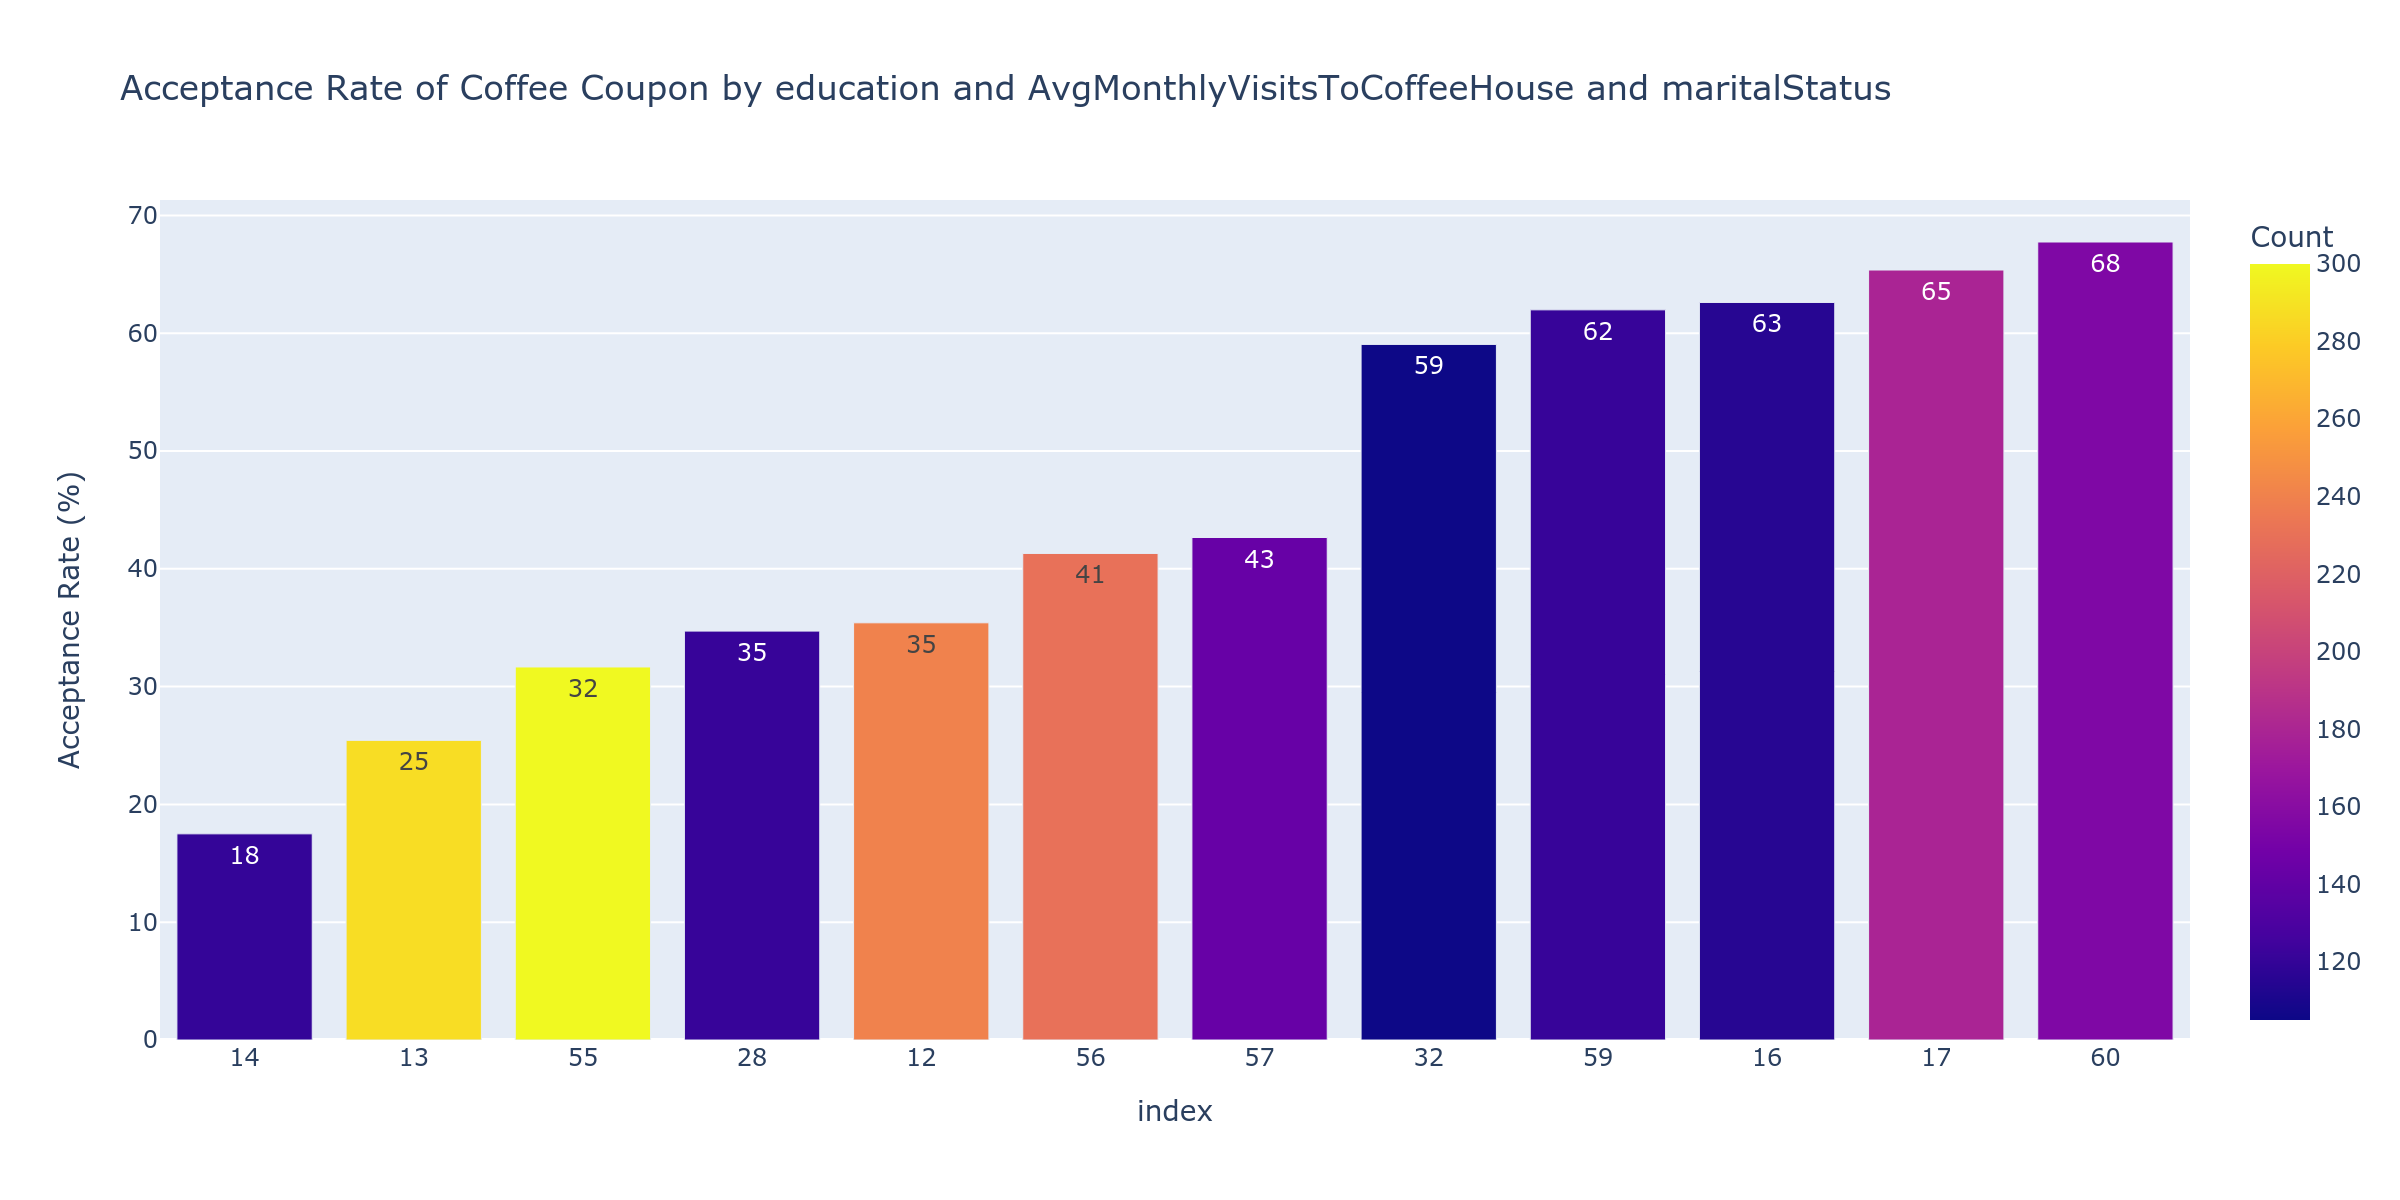

In [319]:
gf = calc_grouped_acceptance_rates(
    df_coffee, columns=["education", "AvgMonthlyVisitsToCoffeeHouse", "maritalStatus"]
).query("Count > 100")
Image(plot_grouped_acceptance_rates(gf))

Display the grouped frame to understand the indices in terms of the variables

In [320]:
display(gf)

,education,AvgMonthlyVisitsToCoffeeHouse,maritalStatus,Acceptance Rate,Count
14,Bachelors,0.0,Together,17.500000,120.0
13,Bachelors,0.0,Single,25.435540,287.0
55,Some College,0.0,Married,31.666667,300.0
28,Graduate,0.0,Married,34.710744,121.0
12,Bachelors,0.0,Married,35.416667,240.0
56,Some College,0.0,Single,41.304348,230.0
57,Some College,0.0,Together,42.657343,143.0
32,Graduate,2.0,Married,59.047619,105.0
59,Some College,2.0,Married,61.983471,121.0
16,Bachelors,2.0,Married,62.608696,115.0


Single people with some college who visited coffee houses twice accepted 68% of coupons  
Combine the last two results to look at single people who attended college at all, degree or not

In [321]:
education = ["Some College", "Bachelors"]
display(
    calc_acceptance_rate(
        df_coffee.query(
            "education in @education and AvgMonthlyVisitsToCoffeeHouse == 2 and maritalStatus == 'Single'"
        )
    )
)

66.46706586826348

Single people who visited coffee houses twice accepted 66% of coupons

#### Who Didn't Accept Coffee Coupons?

Considering destination, gender, passengers in the car, and if the coupon is redeemable en route

##### Without Regard to Age

In [322]:
# The data is sorted ascending by acceptance rate, so here we want the head, i.e. the lowest acceptance rates
display(
    calc_grouped_acceptance_rates(
        df_coffee,
        columns=["destination", "gender", "passenger", "CanRedeemEnRoute"],
    ).head(5)
)

,destination,gender,passenger,CanRedeemEnRoute,Acceptance Rate,Count
0,Home,Female,None,0,28.333333,300.0
14,Work,Female,None,0,30.364372,247.0
3,Home,Male,None,0,32.608696,276.0
16,Work,Male,None,0,35.714286,224.0
1,Home,Female,None,1,41.538462,130.0


Female drivers with no passengers heading home or to work that could not redeem the coupon en route accepted about 29% of the offered coupons

##### Drivers at Least 45 Years Old

In [323]:
display(
    calc_grouped_acceptance_rates(
        df_coffee.query("age >= 45"),
        columns=["destination", "gender", "passenger", "CanRedeemEnRoute"],
    ).head(5)
)

,destination,gender,passenger,CanRedeemEnRoute,Acceptance Rate,Count
16,Work,Male,None,0,18.750000,48.0
14,Work,Female,None,0,19.607843,51.0
3,Home,Male,None,0,26.666667,45.0
0,Home,Female,None,0,30.769231,65.0
1,Home,Female,None,1,44.827586,29.0


Males or females aged 45 and up driving to work with no passengers that could not redeem the coupon en route accepted about 19% of the offered coupons